Klasifikasi dilakukan menggunakan metode zero-shot classification, yang artinya menggunakan model

In [ ]:
# Import dependencies
!pip install -q transformers sentencepiece

from transformers import pipeline
import pandas as pd
import re
from tqdm.notebook import tqdm

In [ ]:
# Check GPU availability
import torch
useGPU = torch.cuda.is_available()
print(useGPU)  # Should return True

if useGPU:
  print(torch.cuda.get_device_name(0))  # E.g., Tesla T4
else:
  print("No GPU detected. Using CPU...")

True
Tesla T4


In [ ]:
# Load labeled & unlabeled dataset
from google.colab import files

uploaded = files.upload()  # Upload `dataset_labeled.csv` and `dataset_unlabeled.csv`

Saving dataset_labeled.csv to dataset_labeled (1).csv
Saving dataset_unlabeled.csv to dataset_unlabeled (1).csv


In [ ]:
# Read dataset
df_labeled = pd.read_csv('dataset_labeled.csv', sep=';')
df_unlabeled = pd.read_csv('dataset_unlabeled.csv', sep=';')

df_labeled.columns = ['tweet', 'label']
df_unlabeled.columns = ['id', 'tweet']

df_labeled.head()

,tweet,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [ ]:
# Simple EDA
print("Jumlah data label:", len(df_labeled))
print("Distribusi label:\n", df_labeled['label'].value_counts())
df_labeled['text_length'] = df_labeled['tweet'].apply(lambda x: len(str(x)))
print(df_labeled['text_length'].describe())

Jumlah data label: 5000
Distribusi label:
 label
Politik                    2972
Sosial Budaya               587
Ideologi                    400
Pertahanan dan Keamanan     400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: count, dtype: int64
count    5000.000000
mean      268.815600
std       314.762818
min        45.000000
25%       168.000000
50%       217.000000
75%       280.000000
max      4893.000000
Name: text_length, dtype: float64


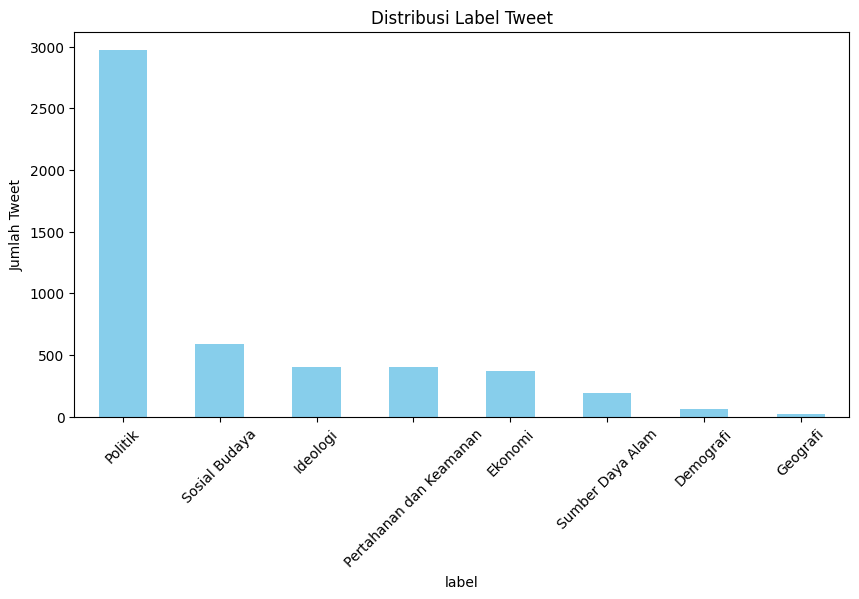

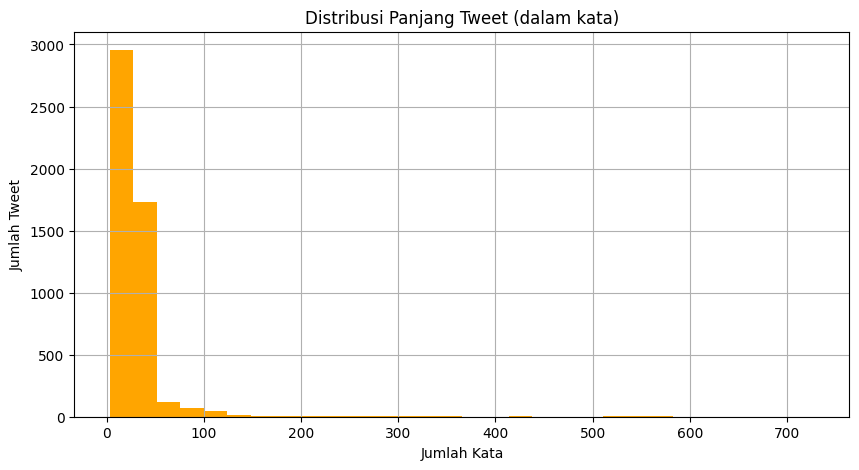

In [ ]:
# EDA visualization
import matplotlib.pyplot as plt

# Check class distribution
label_counts = df_labeled['label'].value_counts()
label_counts.plot(kind='bar', title='Distribusi Label Tweet', figsize=(10, 5), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Jumlah Tweet")
plt.show()

# Tweet length analysis
df_labeled['length'] = df_labeled['tweet'].apply(lambda x: len(str(x).split()))
df_labeled['length'].hist(bins=30, figsize=(10, 5), color='orange')
plt.title('Distribusi Panjang Tweet (dalam kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Tweet')
plt.show()

In [ ]:
# Preprocessing (sanitize text and regularize to lowercase)
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#[A-Za-z0-9_]+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.strip().lower()

df_labeled['cleaned_tweet'] = df_labeled['tweet'].apply(clean_tweet)
df_unlabeled['cleaned_tweet'] = df_unlabeled['tweet'].apply(clean_tweet)

df_labeled.head()

,tweet,label,text_length,length,cleaned_tweet
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,184,20,kunjungan prabowo ini untuk meresmikan dan men...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,184,22,rt anies dapat tepuk tangan meriah saat jadi r...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,254,35,y8heyaiogmfg8y emng bener sih pendukung 01 ada...
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,301,40,rt 0hhztbqvgx7qtfwrg9zmhk7q sewaktu anies bers...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,101,13,anies baswedan harap asn termasuk tni dan polr...


In [ ]:
df_unlabeled.head()

,id,tweet,cleaned_tweet
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,lu mau org2 prodemokrasi di negara ini bisa pu...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kikidaliyo ganjar pranowo itulah beliau sosok...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa melakukan itu semua d...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru yg gak nyambung junjungan elu aomkm...


In [ ]:
# Zero-shot classifier
# English labels to fit the model's language
candidate_labels = [
    "Ideology", "Politics", "Economy", "Social Culture",
    "Defense and Security", "Natural Resources", "Geography", "Demographics"
]

# Label map to match English and Indonesian prediction
label_map = {
    "Politik": "Politics",
    "Ekonomi": "Economy",
    "Sosial Budaya": "Social Culture",
    "Pertahanan dan Keamanan": "Defense and Security",
    "Sumber Daya Alam": "Natural Resources",
    "Geografi": "Geography",
    "Demografi": "Demographics",
    "Ideologi": "Ideology"
}

df_labeled['mapped_label'] = df_labeled['label'].map(label_map)
df_labeled = df_labeled[df_labeled['mapped_label'].notnull()]

# 0 = GPU, -1 = CPU
device = 0 if useGPU else -1
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli", device=device)

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
# Batch of 16 tweets per GPU batch
if useGPU:
  BATCH_SIZE = 16

  def batch_classify(texts, labels, batch_size=16):
      predictions = []
      for i in tqdm(range(0, len(texts), batch_size)):
          batch = texts[i:i+batch_size]
          results = classifier(batch, labels)
          for result in results:
              predictions.append(result['labels'][0])
      return predictions

# Classify labeled dataset
tqdm.pandas()
if useGPU:
  df_labeled['predicted'] = batch_classify(df_labeled['cleaned_tweet'].tolist(), candidate_labels)
else:
  df_labeled['predicted'] = df_labeled['cleaned_tweet'].progress_apply(
      lambda x: classifier(x, candidate_labels)['labels'][0]
  )

  0%|          | 0/5000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Model evaluation in the same language
from sklearn.metrics import classification_report
print(classification_report(df_labeled['mapped_label'], df_labeled['predicted']))

                      precision    recall  f1-score   support

Defense and Security       0.48      0.34      0.40       400
        Demographics       0.06      0.13      0.08        62
             Economy       0.36      0.44      0.40       367
           Geography       0.06      0.10      0.07        20
            Ideology       0.17      0.51      0.26       400
   Natural Resources       0.17      0.34      0.23       192
            Politics       0.71      0.45      0.55      2972
      Social Culture       0.20      0.24      0.22       587

            accuracy                           0.41      5000
           macro avg       0.28      0.32      0.28      5000
        weighted avg       0.54      0.41      0.44      5000



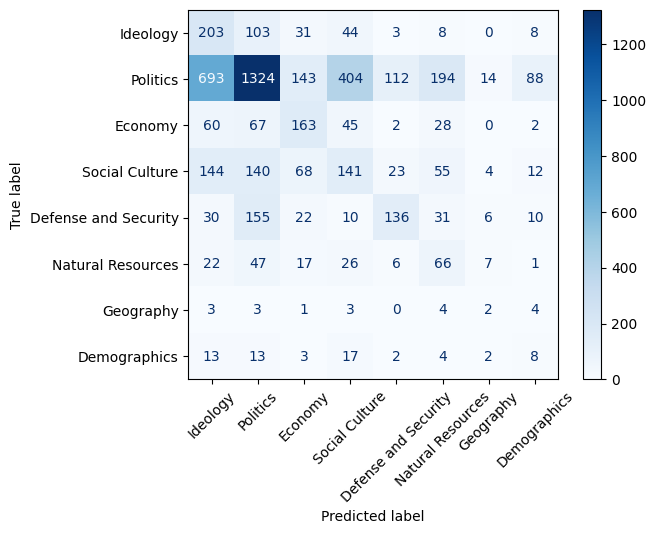

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df_labeled['mapped_label'], df_labeled['predicted'], labels=candidate_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=candidate_labels)
disp.plot(xticks_rotation=45, cmap='Blues', values_format='d')

In [ ]:
# Apply prediction to unlabeled dataset
df_unlabeled['predicted'] = batch_classify(df_unlabeled['cleaned_tweet'].tolist(), candidate_labels)
df_unlabeled.head()

  0%|          | 0/63 [00:00<?, ?it/s]

,id,tweet,cleaned_tweet,predicted
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,lu mau org2 prodemokrasi di negara ini bisa pu...,Politics
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya soal hutang luar negeri dia me...,Economy
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kikidaliyo ganjar pranowo itulah beliau sosok...,Ideology
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa melakukan itu semua d...,Social Culture
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru yg gak nyambung junjungan elu aomkm...,Social Culture


In [ ]:
# Save prediction results
predicted_result = 'predicted_unlabeled.csv'
df_unlabeled.to_csv(predicted_result, index=False)
files.download(predicted_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# link github : https://github.com/anahyunaa/miniprojectMachineLearning